## Description

### This file is used for spliting the dataset, and it will consist of the following subset:
- image
  - {frame_id}.png &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; # Rendered image of a face
- label
  - {frame_id}\_seg.png &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; # Segmentation image, where each pixel has an integer value mapping to the categories below
- ldmks
  - {frame_id}\_ldmks.txt &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; # Landmark annotations for 70 facial landmarks (x, y) coordinates for every row

In [1]:
import os
import cv2
import shutil
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the dataset path and target folder
ROOT_PATH = 'D:/sythetic_data'
DATASET_NAME ='dataset_100'# choose the dataset 
DATASET_PATH = os.path.join(ROOT_PATH, DATASET_NAME)
IMAGE_FOLDER = os.path.join(DATASET_PATH, 'image')
LABEL_FOLDER = os.path.join(DATASET_PATH, 'label')
LDMKS_FOLDER = os.path.join(DATASET_PATH, 'ldmks')

In [3]:
# If the destination folder does not exist, create it
os.makedirs(IMAGE_FOLDER, exist_ok=True)
os.makedirs(LABEL_FOLDER, exist_ok=True)
os.makedirs(LDMKS_FOLDER, exist_ok=True)

In [4]:
# Traverse all files in the dataset folder
for filename in os.listdir(DATASET_PATH):
    file_path = os.path.join(DATASET_PATH, filename)
    
    # Check if it is a file (ignore folders)
    if os.path.isfile(file_path):
        # If the file name matches the image file format
        if filename.endswith('.png')and not filename.endswith('_seg.png'):
            shutil.move(file_path, os.path.join(IMAGE_FOLDER, filename))
        
        # If the file name matches the mask file format
        elif filename.endswith('_seg.png'):
            shutil.move(file_path, os.path.join(LABEL_FOLDER, filename))
            
        # If the file name matches the ldmks file formaty
        elif filename.endswith('_ldmks.txt'):
            shutil.move(file_path, os.path.join(LDMKS_FOLDER, filename))

###  Analyze the class distribution in the mask image and takes one image as an example :

In [5]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [6]:
image_id = '000000'
image_name = image_id + ".png"
mask_name = image_id + "_seg.png"
image_path = os.path.join(IMAGE_FOLDER, image_name)
mask_path = os.path.join(LABEL_FOLDER, mask_name)

In [7]:
# show a image-mask pairs
def showImg(image_path, mask_path):
    img = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(mask_path, cv2.COLOR_BGR2GRAY)
    print("img_size:", img.shape[:2] )
    print("mask_size:", mask.shape[:2] )
    mask = np.stack((mask,)*3, axis=-1)
    mid = np.zeros((IMG_HEIGHT, 50, 3))
    tmp = np.concatenate((img, mid), axis = 1)
    show_img = np.concatenate((tmp, mask), axis = 1)
    show_img = show_img.astype(np.uint8)
    plt.imshow(show_img)
    plt.show()

img_size: (512, 512)
mask_size: (512, 512)


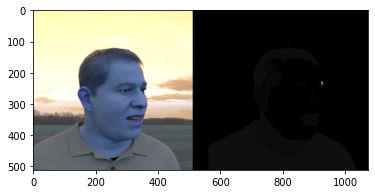

In [8]:
showImg(image_path, mask_path)

In [9]:
# Open the mask image and convert it into an numpy array
mask_example = Image.open(mask_path)
mask_array = np.array(mask_example)

In [10]:
# Print all unique values (category labels) # class RIGHT_EAR = 7,here doesn't show 
print("class label: ", np.unique(mask_array))

class label:  [  0   1   2   3   4   5   6   8   9  10  11  12  13  15 255]


In [11]:
# Count the number of pixels for each label
unique, counts = np.unique(mask_array, return_counts=True)
label_counts = dict(zip(unique, counts))
print("The number of pixels per class:", label_counts) 

The number of pixels per class: {0: 157627, 1: 34444, 2: 2360, 3: 72, 4: 143, 5: 138, 6: 362, 8: 2799, 9: 552, 10: 473, 11: 713, 12: 10396, 13: 10374, 15: 41657, 255: 34}


## Visualizing
### plot here the img and mappings 
- mask with orginal classes 
   -   0: 'Background',
        1: 'Skin',
        2: 'Nose',
        3: 'Right_Eye',
        4: 'Left_Eye',
        5: 'Right_Brow',
        6: 'Left_Brow',
        7: 'Right_Ear',
        8: 'Left_Ear',
        9: 'Mouth_Interior',
        10: 'Top_Lip',
        11: 'Bottom_Lip',
        12: 'Neck',
        13: 'Hair',
        14: 'Beard',
        15: 'Clothing',
        16: 'Glasses',
        17: 'Headwear',
        18: 'Facewear',
        255: "Ignore",
- assigned skin and nose to the skin class and the remaining annotations to the non-skin class
     - 0: "Non-Skin",
        1: "Skin",
        255: "Ignore",

In [44]:
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [45]:
def remap_original(mask):
    """Remap mask for original image&mask"""
    class_remapping_exp = {
        0: [0],
        1: [1],
        2: [2],
        3: [3],
        4: [4],
        5: [5],
        6: [6],
        7: [7],
        8: [8],
        9: [9],
        10: [10],
        11: [11],
        12: [12],
        13: [13],
        14: [14],
        15: [15],
        16: [16],
        17: [17],
        18: [18],
        255: [255],
    }
    classes_exp = {
        0: 'Background',
        1: 'Skin',
        2: 'Nose',
        3: 'Right_Eye',
        4: 'Left_Eye',
        5: 'Right_Brow',
        6: 'Left_Brow',
        7: 'Right_Ear',
        8: 'Left_Ear',
        9: 'Mouth_Interior',
        10: 'Top_Lip',
        11: 'Bottom_Lip',
        12: 'Neck',
        13: 'Hair',
        14: 'Beard',
        15: 'Clothing',
        16: 'Glasses',
        17: 'Headwear',
        18: 'Facewear',
        255: "Ignore",
    }
    colormap = get_remapped_colormap(class_remapping_exp)
    remapped_mask = remap_mask(mask, class_remapping=class_remapping_exp)
    return remapped_mask, classes_exp, colormap


def plot_original(img_path, mask_path):
    """
    Generates plot of image and rgb mask with colorbar for original images
    :param img_path: Path to input image
    :param mask_path: Path to input segmentation mask
    :param experiment: int for different Experimental setup 
    :return: plot of image and rgb mask with class colorbar
    """
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.COLOR_BGR2GRAY)
    remapped_mask, classes_exp, colormap = remap_original(mask)
    return plot_images(img, remapped_mask, colormap, classes_exp)


def remap_simple(mask):
    """Remap mask which smplified classes"""
    class_remapping_exp = {
         0: [0,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],
         1: [1,2],
         255: [255],
    }

    classes_exp = {
        0: "Non-Skin",
        1: "Skin",
        255: "Ignore",
    }

    colormap = get_remapped_colormap(class_remapping_exp)
    remapped_mask = remap_mask(mask, class_remapping=class_remapping_exp)
    return remapped_mask, classes_exp, colormap


def plot_simple(img_path, mask_path):
    """
    Function for plotting of mask with smplified classes
    :param img: 3D ndarray of input image
    :param mask: 2D/3D ndarray of input segmentation mask with class ids
    :return: plot of image and rgb mask with class colorbar
    """

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.COLOR_BGR2GRAY)
    remapped_mask, classes_exp, colormap = remap_simple(mask)
    return plot_images(img, remapped_mask, colormap, classes_exp)
def get_colormap():
    """
    Returns colormap
    :return: ndarray of rgb colors
    """
    return np.asarray(
        [
            [58, 0, 82],
            [253, 234, 39],
            [255, 156, 201],
            [99, 0, 255],
            [255, 0, 0],
            [255, 0, 165],
            [255, 255, 255],
            [141, 141, 141],
            [255, 218, 0],
            [173, 156, 255],
            [73, 73, 73],
            [250, 213, 255],
            [255, 156, 156],
            [99, 255, 0],
            [157, 225, 255],
            [255, 89, 124],
            [173, 255, 156],
            [255, 60, 0],
            [40, 0, 255],
        ]
    )


def remap_mask(mask, class_remapping, ignore_label=255):
    """
    Remaps mask class ids
    :param mask: 2D/3D ndarray of input segmentation mask
    :param class_remapping: dictionary that indicates class remapping
    :param ignore_label: class ids to be ignored
    :return: 2D/3D ndarray of remapped segmentation mask
    """
    classes = []
    for key, val in class_remapping.items():
        for cls in val:
            classes.append(cls)
    assert len(classes) == len(set(classes))

    N = max(len(classes), mask.max() + 1)
    remap_array = np.full(N, ignore_label, dtype=np.uint8)
    for key, val in class_remapping.items():
        for v in val:
            remap_array[v] = key
    return remap_array[mask]


def get_remapped_colormap(class_remapping):
    """
    Generated colormap of remapped classes
    Classes that are not remapped are indicated by the same color across all experiments
    :param class_remapping: dictionary that indicates class remapping
    :return: 2D ndarray of rgb colors for remapped colormap
    """
    colormap = get_colormap()
    remapped_colormap = {}
    for key, val in class_remapping.items():
        if key == 255:
            remapped_colormap.update({key: [0, 0, 0]})
        else:
            remapped_colormap.update({key: colormap[val[0]]})
    return remapped_colormap


def mask_to_colormap(mask, colormap):
    """
    Genarates RGB mask colormap from mask with class ids
    :param mask: 2D/3D ndarray of input segmentation mask
    :param colormap: dictionary that indicates color corresponding to each class
    :return: 3D ndarray Generated RGB mask
    """
    rgb = np.zeros(mask.shape[:2] + (3,), dtype=np.uint8)
    for label, color in colormap.items():
        rgb[mask == label] = color
    return rgb


def plot_images(img, remapped_mask, remapped_colormap, classes_exp):
    """
    Generates plot of Image and RGB mask with class colorbar
    :param img: 3D ndarray of input image
    :param remapped_mask: 2D/3D ndarray of input segmentation mask with class ids
    :param remapped_colormap: dictionary that indicates color corresponding to each class
    :param classes_exp: dictionary of classes names and corresponding class ids
    :param experiment: experimental setup
    :return: plot of image and rgb mask with class colorbar
    """
    mask_rgb = mask_to_colormap(remapped_mask, colormap=remapped_colormap)

    fig, axs = plt.subplots(1, 2, figsize=(26, 7))
    plt.subplots_adjust(left=1 / 16.0, right=1 - 1 / 16.0, bottom=1 / 8.0, top=1 - 1 / 8.0)
    axs[0].imshow(img)
    axs[0].axis("off")

    img_u_labels = np.unique(remapped_mask)
    c_map = []
    cl = []
    for i_label in img_u_labels:
        if i_label == 255:  # Skip ignore_label (255)
            continue
        for i_key, i_color in remapped_colormap.items():
            if i_label == i_key:
                c_map.append(i_color)
        for i_key, i_class in classes_exp.items():
            if i_label == i_key:
                cl.append(i_class)
    cl = np.asarray(cl)
    cmp = np.asarray(c_map) / 255
    cmap_mask = LinearSegmentedColormap.from_list("seg_mask_colormap", cmp, N=len(cmp))
    im = axs[1].imshow(mask_rgb, cmap=cmap_mask)
    intervals = np.linspace(0, 255, num=len(c_map) + 1 )
    ticks = intervals[:-1] + int((intervals[1] - intervals[0]) / 2)
    divider = make_axes_locatable(axs[1])
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    cbar1 = fig.colorbar(mappable=im, cax=cax1, ticks=ticks, orientation="vertical")
    cbar1.ax.set_yticklabels(cl)
    axs[1].axis("off")
    fig.tight_layout()
    plt.show()

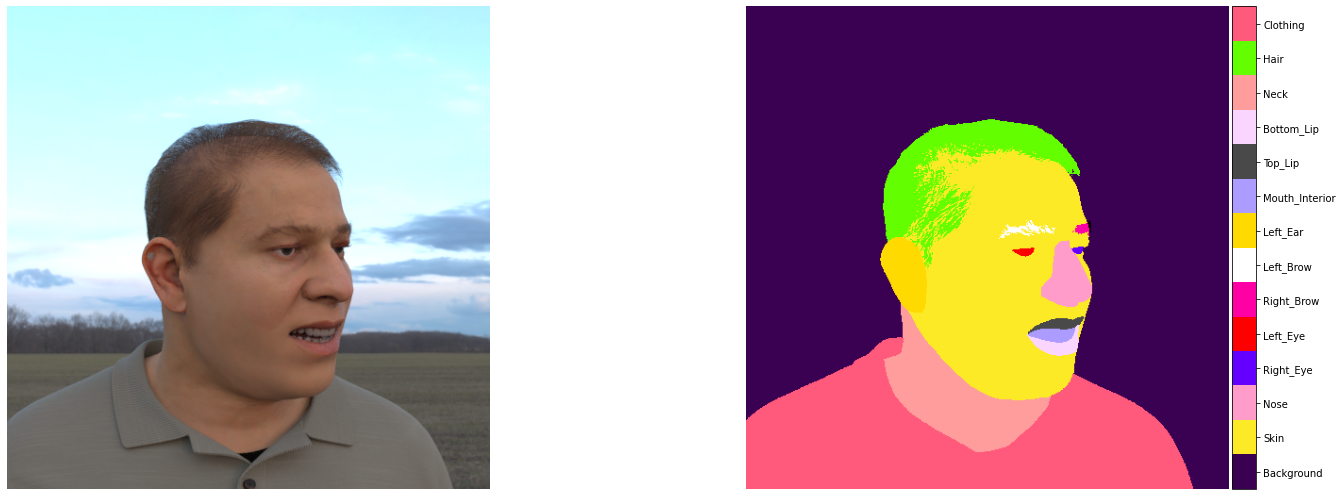

In [47]:
plot_original(image_path, mask_path)

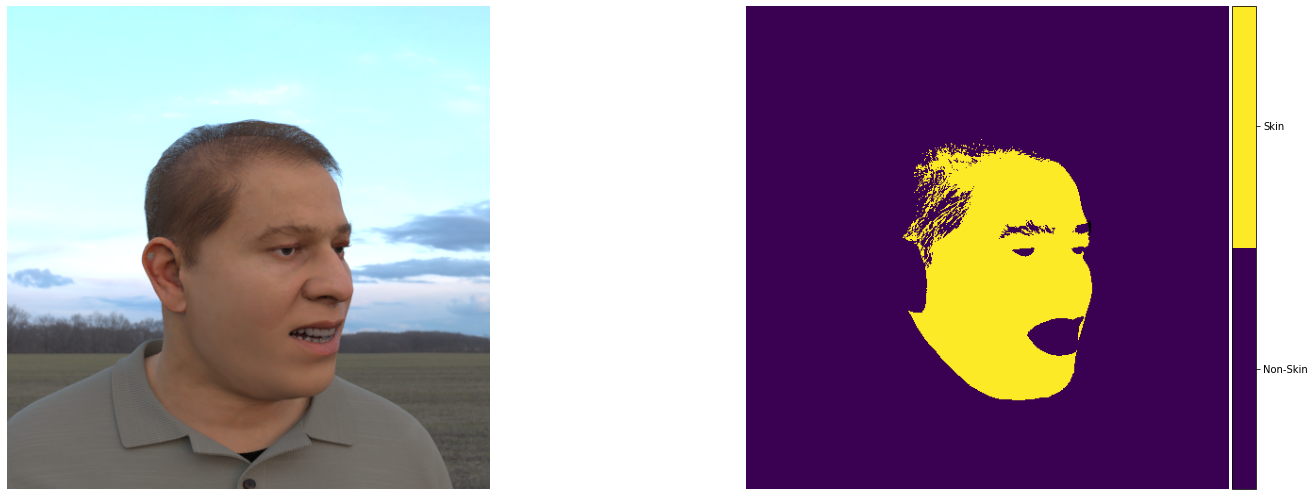

In [48]:
plot_simple(image_path, mask_path)

## Downscaled the images from 512 x 512 to 256x 256 pixels

In [123]:
from glob import glob
output_img_dir = os.path.join(DATASET_PATH,"256,256","images")
output_mask_dir = os.path.join(DATASET_PATH,"256,256","masks")
 
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

for img_path_downscaled, mask_path_downscaled in zip(glob(os.path.join(IMAGE_FOLDER, "*.png")), glob(os.path.join(LABEL_FOLDER, "*.png"))):
    
    img_downscaled = cv2.imread(img_path_downscaled)
    mask_downscaled = cv2.imread(mask_path_downscaled, cv2.IMREAD_UNCHANGED)
    
    d_img = cv2.resize(img_downscaled, (256, 256), interpolation=cv2.INTER_AREA)
    d_mask = cv2.resize(mask_downscaled, (256, 256), interpolation=cv2.INTER_NEAREST)
    
    img_output_path = os.path.join(output_img_dir, os.path.basename(img_path_downscaled))
    mask_output_path = os.path.join(output_mask_dir, os.path.basename(mask_path_downscaled))
    
    cv2.imwrite(img_output_path, d_img)
    cv2.imwrite(mask_output_path, d_mask)

img_size: (256, 256)
mask_size: (256, 256)


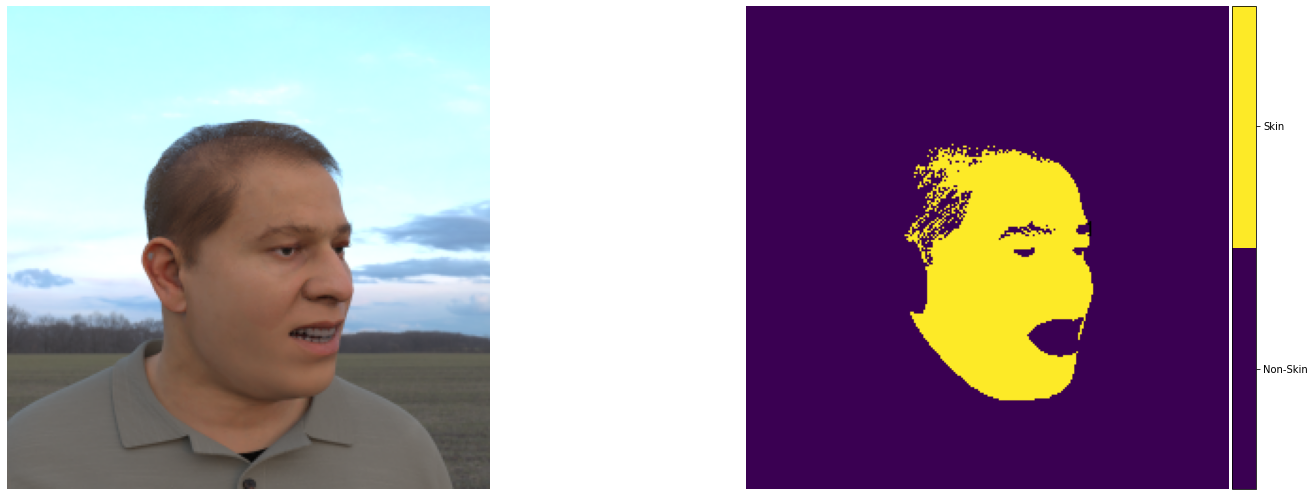

In [141]:
image_id = '000000'
image_name = image_id + ".png"
mask_name = image_id + "_seg.png"
image_path = os.path.join(output_img_dir, image_name)
mask_path = os.path.join(output_mask_dir, mask_name)
img = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)
mask = cv2.imread(mask_path, cv2.COLOR_BGR2GRAY)
print("img_size:", img.shape[:2] )
print("mask_size:", mask.shape[:2] )
plot_simple(image_path, mask_path)

## Dilation operation
### here applied dilation operation to the pixels annotate das non-skin as mentioned in the paper.

In [145]:
input_mask_folder = os.path.join(DATASET_PATH,"256,256","masks")
output_folder = os.path.join(DATASET_PATH,"256,256","masks_di")
os.makedirs(output_folder, exist_ok=True)

mask_files = [f for f in os.listdir(input_mask_folder) if f.endswith('_seg.png')]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
for mask in mask_files:
    annotation = cv2.imread(os.path.join(input_mask_folder, mask), 0)
    
    dilated_annotation = np.zeros_like(annotation)

    unique_classes = np.unique(annotation)
    for class_id in unique_classes:
        class_mask = (annotation == class_id).astype(np.uint8)

        if class_id in [1,2,255]:  # skin regions 
            dilated_annotation = np.where(class_mask == 1, class_id, dilated_annotation)
        else:
            dilated_mask = cv2.dilate(class_mask, kernel, iterations=1)# dilation
            dilated_annotation = np.where(dilated_mask == 1, class_id, dilated_annotation)
            
    output_path = os.path.join(output_folder, mask)
    cv2.imwrite(output_path, dilated_annotation)   

In [146]:
mask_files_in_output_folder = [f for f in os.listdir(output_folder) if f.endswith('_seg.png')]
print(f"number of masks: {len(mask_files_in_output_folder)}")    

number of masks: 100


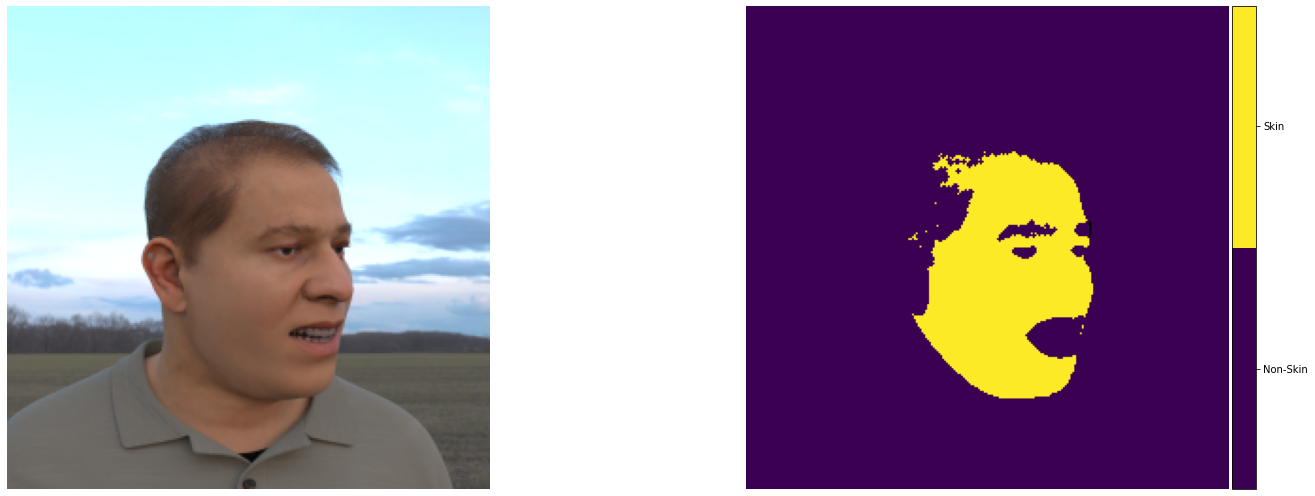

class label:  [  0   1   2   3   4   5   6   8   9  10  11  12  13  15 255]


In [152]:
msk_path = r'D:\sythetic_data\dataset_100\256,256\masks_di\000000_seg.png'
plot_simple(image_path, msk_path)
mask_example = Image.open(msk_path)
mask_array = np.array(mask_example)
print("class label: ", np.unique(mask_array))

## Check if there are images including incorrect label

In [157]:
IMG_PATH = os.path.join(ROOT_PATH,'dataset_100','256,256','images')
MSK_PATH = os.path.join(ROOT_PATH,'dataset_100','256,256','masks_di')
image_files = sorted([f for f in os.listdir(IMG_PATH) if f.endswith('.png')])
mask_files = sorted([f for f in os.listdir(MSK_PATH) if f.endswith('.png')])

In [158]:
#Store the image file name with incorrect label
mislabeled_files = []

valid_categories = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 255]

for image_file, mask_file in zip(image_files, mask_files):
    # Check if the filename matches
    if image_file.split('.')[0] != mask_file.split('_seg')[0]:
        mislabeled_files.append(image_file)
        continue
    
   
    image = Image.open(os.path.join(IMAGE_FOLDER, image_file))
    mask = Image.open(os.path.join(LABEL_FOLDER, mask_file))

    # Check if the image and mask sizes match
    if image.size != mask.size:
        mislabeled_files.append(image_file)
        continue
    
    # Check if the mask contains Invalid labels
    mask_array = np.array(mask)
    unique_labels = np.unique(mask_array)  
    if not np.all(np.isin(unique_labels, valid_categories)):  
        mislabeled_files.append(image_file)
        continue
        
if mislabeled_files: 
    output_filename = "mislabeled_files.txt"
    output_path = os.path.join(DATASET_PATH, output_filename)
    with open(output_path, 'w') as f:
        for file in mislabeled_files:
            f.write(f"{file}\n")
else:
    print("all labels are correct")
        

all labels are correct


## Prepare training set, validation set and test set

In [159]:
from sklearn.model_selection import train_test_split

PATH = os.path.join(ROOT_PATH,'dataset_100','256,256')
# Dataset path
images_dir = os.path.join(PATH, 'images')
labels_dir = os.path.join(PATH,'masks_di')

# Output path
train_images_dir = os.path.join(PATH, 'train/images')
train_labels_dir = os.path.join(PATH, 'train/labels')
val_images_dir = os.path.join(PATH, 'val/images')
val_labels_dir = os.path.join(PATH, 'val/labels')
test_images_dir = os.path.join(PATH, 'test/images')
test_labels_dir = os.path.join(PATH, 'test/labels')

# Create folders
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

# Get file_names
image_ = sorted(os.listdir(images_dir))
label_ = sorted(os.listdir(labels_dir))


assert len(image_) == len(label_)

# Split the datasset train:val:test = 6:2:2 randomly
train_imgs, temp_imgs, train_lbls, temp_lbls = train_test_split(image_, label_, test_size=0.4, random_state=42)
val_imgs, test_imgs, val_lbls, test_lbls = train_test_split(temp_imgs, temp_lbls, test_size=0.5, random_state=42)

#Copy files to the destination folder
def copy_files(file_list, src_dir, dest_dir):
    for file_name in file_list:
        shutil.copy(os.path.join(src_dir, file_name), os.path.join(dest_dir, file_name))


copy_files(train_imgs, images_dir, train_images_dir)
copy_files(train_lbls, labels_dir, train_labels_dir)


copy_files(val_imgs, images_dir, val_images_dir)
copy_files(val_lbls, labels_dir, val_labels_dir)


copy_files(test_imgs, images_dir, test_images_dir)
copy_files(test_lbls, labels_dir, test_labels_dir)

In [160]:
# Output structure and size of each folder

def print_directory_structure(base_dir):
    dataset_types = ['train', 'val', 'test']
    structure = {}

    for dataset in dataset_types:
        images_dir = os.path.join(base_dir, dataset, 'images')
        labels_dir = os.path.join(base_dir, dataset, 'labels')
        
       
        num_images = len(os.listdir(images_dir))
        num_labels = len(os.listdir(labels_dir))
        
        structure[dataset] = {
            'images': num_images,
            'labels': num_labels
        }
    
    print("The structure and size of each folder：")
    for dataset in structure:
        print(f"{dataset.capitalize()}/")
        print(f"  ├── images/  ({structure[dataset]['images']} files)")
        print(f"  └── labels/  ({structure[dataset]['labels']} files)")
        print()

print_directory_structure(DATASET_PATH)        

The structure and size of each folder：
Train/
  ├── images/  (60 files)
  └── labels/  (60 files)

Val/
  ├── images/  (20 files)
  └── labels/  (20 files)

Test/
  ├── images/  (20 files)
  └── labels/  (20 files)

